## Load Imports

In [1]:
import cv2
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageOps
import numpy as np
import math

## Helper functions for handling images

In [2]:

def openImage(imagePath):
    return Image.open(imagePath)

def showImage(image, title="", figsize=(10, 10)):
  # Display image using matplotlib
  plt.figure(figsize=figsize)
  plt.imshow(image)
  if title:
    plt.title(title)
  plt.axis('off')  # Hide axes
  plt.show()

def saveImage(image, path):
  image.save(path)

In [3]:
def getTestImage(i=1, extension="png"):
  return openImage(f'./screenshots/test_{i}.{extension}')

## Manipulating Images

Cropping

In [4]:
def cropImage(image):
    # Convert image to NumPy array
    imageArray = np.array(image)
    height, width, _ = imageArray.shape

    # Function to check if all pixels in a row are the same
    def isRowUniform(row):
        return np.all(row == row[0], axis=0).all()

    # Start from the center and look for rows that are uniform in color
    center = height // 2
    top = center
    bottom = center

    # Expand upwards to find the top boundary
    while top > 0 and (not isRowUniform(imageArray[top, :]) or center - top < 100):
        top -= 1

    # Expand downwards to find the bottom boundary
    while bottom < height and (not isRowUniform(imageArray[bottom, :]) or bottom - center < 100):
        bottom += 1

    # Add a max padding of 100 pixels on both sides, keeping boundaries within limits
    top = max(0, top - 100)
    bottom = min(height, bottom + 100)

    # Crop the image
    croppedArray = imageArray[top:bottom, :]
    croppedImage = Image.fromarray(croppedArray)

    return croppedImage


Get Mask by removing grayscale pixels

In [5]:
def mask_grayscale(image, threshold=60, verbose=False):
    # Convert image to RGB if it's not already
    image = image.convert('RGB')

    # Get pixel data
    pixels = image.load()
    width, height = image.size

    # Create a new image for the mask
    masked_image = Image.new('RGB', (width, height))
    masked_pixels = masked_image.load()

    for x in range(width):
        for y in range(height):
            pixel = pixels[x, y]

            # Check if the pixel is grayscale (R ≈ G ≈ B within the threshold)
            if abs(pixel[0] - pixel[1]) <= threshold and abs(pixel[1] - pixel[2]) <= threshold and abs(pixel[0] - pixel[2]) <= threshold:
                masked_pixels[x, y] = (0, 0, 0)  # Set grayscale pixels to black
            else:
                masked_pixels[x, y] = pixel  # Keep non-grayscale pixels

    if verbose:
        showImage(masked_image)

    return masked_image

Convert the binary image

In [6]:
def black_and_white(image, threshold=128, verbose=False):
    # Convert the image to grayscale
    grayscale_image = image.convert("L")  # Convert to grayscale mode (L)

    # Convert to NumPy array for thresholding
    grayscale_array = np.array(grayscale_image)

    # Apply threshold (128 as default midpoint)
    bw_array = np.where(grayscale_array > threshold, 255, 0).astype(np.uint8)

    # Convert back to PIL Image
    bw_image = Image.fromarray(bw_array, mode="L")

    # Display the image if verbose
    if verbose:
        showImage(bw_image)

    return bw_image

## Draw on the image

In [7]:
def evaluateGrid(originalImage, grid, hexSide):
    # Create a drawing context for the PIL Image
    draw = ImageDraw.Draw(originalImage)
    index_mapping = [4, 1, 2, 5, 0, 3]

    # Helper function to calculate vertices of a hexagon
    def hexVertices(cx, cy, side, scale=1):
        vertices = []
        for i in range(6):
            angle = math.radians(60 * i)  # Hexagon angles (60 degrees apart)
            x = cx + scale * side * math.cos(angle)
            y = cy + scale * side * math.sin(angle)
            vertices.append((x, y))
        return vertices


    # Iterate over the grid
    for i in range(len(grid)):
        for j in range(len(grid[i])):
            # Get the center of the current hexagon
            hex = grid[i][j]
            cx, cy = hex.center
            links = hex.links
            goalDimension = hex.endDimension
            boxDimension = hex.startDimension
            dash = hex.overlapSide

            outline = hexVertices(cx, cy, hexSide)
            linksOutline = hexVertices(cx, cy, hexSide, scale=0.9)
            dimensionOutline = hexVertices(cx, cy, hexSide, scale=0.4)
            # Draw the center of the hexagon in blue
            draw.ellipse(
                (cx - 2, cy - 2, cx + 2, cy + 2),  # Bounding box for the circle
                fill=(0, 0, 255)
            )

            draw.polygon(outline, outline=(255, 0, 0))  # Red outline for the hexagon

            for linkIndex in range(6):
              if links[index_mapping[linkIndex]] == 1:
                startVertex = linksOutline[linkIndex]
                endVertex = linksOutline[(linkIndex + 1) % 6]
                draw.line([startVertex, endVertex], fill=(0, 255, 0), width=2)

            for boxDimIndex in range(6):
              if boxDimension == index_mapping[boxDimIndex]:
                startVertex = dimensionOutline[boxDimIndex]
                endVertex = dimensionOutline[(boxDimIndex + 1) % 6]
                draw.line([startVertex, endVertex], fill=(255, 255, 0), width=2)

            for goalDimIndex in range(6):
              if goalDimension == index_mapping[goalDimIndex]:
                startVertex = dimensionOutline[goalDimIndex]
                endVertex = dimensionOutline[(goalDimIndex + 1) % 6]
                draw.line([startVertex, endVertex], fill=(255, 0, 255), width=2)

            for dashIndex in range(6):
              if dash == index_mapping[dashIndex]:
                startVertex = linksOutline[dashIndex]
                endVertex = linksOutline[(dashIndex + 1) % 6]
                draw.line([startVertex, endVertex], fill=(0, 0, 0), width=3)

    return originalImage

In [8]:
def drawHexagons(image, hexagons, hexSide, subSide, color=(255, 0, 0), verbose=False):
    # Convert image to RGB mode if not already in RGB
    if image.mode != 'RGB':
        image = image.convert('RGB')

    # Create a drawing context for the image
    draw = ImageDraw.Draw(image)

    for points in hexagons:
      for cx, cy in points:
          # Calculate the vertices of the hexagon centered at (cx, cy)
          vertices = [
              (cx + hexSide * math.cos(math.radians(angle)),
              cy + hexSide * math.sin(math.radians(angle)))
              for angle in [0, 60, 120, 180, 240, 300]
              # for angle in [30, 90, 150, 210, 270, 330]
          ]

          subVertices = [
            (cx + subSide * math.cos(math.radians(angle)),
            cy + subSide * math.sin(math.radians(angle)))
            for angle in [0, 60, 120, 180, 240, 300]
            # for angle in [30, 90, 150, 210, 270, 330]
          ]


          draw.polygon(vertices, outline=color)
          draw.polygon(subVertices, outline=color)

    if verbose:
        showImage(image)

    return image

In [9]:
def drawPolygons(image, polygons, drawVertices=True, color=(255, 0, 0), vertexColor=(255, 255, 0), vertexRadius=3, verbose=False):
    # Convert image to RGB mode if not already in RGB
    if image.mode != 'RGB':
        image = image.convert('RGB')

    # Create a drawing context for the image
    draw = ImageDraw.Draw(image)

    for poly in polygons:
        poly = [(x, y) for x, y in poly]
        draw.polygon(poly, outline=color)

        if drawVertices:
            for point in poly:
                # Draw vertices as yellow circles
                draw.ellipse((point[0] - vertexRadius, point[1] - vertexRadius, point[0] + vertexRadius, point[1] + vertexRadius), fill=vertexColor)

    if verbose:
        showImage(image)

    return image

## Helper Functions for main function

In [10]:
def distanceSq(p1, p2):
    """Calculates the squared Euclidean distance between two points."""
    return (p1[0] - p2[0])**2 + (p1[1] - p2[1])**2

def eliminate_close_points(polygon, threshold=10):
    # Initialize the simplified polygon
    simplified_polygon = []

    # A temporary cluster to hold close points
    cluster = []

    for point in polygon:
        if not cluster:
            # Start a new cluster with the current point
            cluster.append(point)
        else:
            # Calculate the centroid of the current cluster
            centroid_x = sum(p[0] for p in cluster) / len(cluster)
            centroid_y = sum(p[1] for p in cluster) / len(cluster)
            centroid = [centroid_x, centroid_y]

            # Check if the current point is close to the centroid
            d = distanceSq(centroid, point)
            if d <= (threshold**2):
                cluster.append(point)
            else:
                # Append the rounded centroid of the current cluster to the simplified polygon
                simplified_polygon.append([round(centroid_x), round(centroid_y)])
                # Start a new cluster with the current point
                cluster = [point]

    # Process the last cluster (if any points remain unprocessed)
    if cluster:
        centroid_x = sum(p[0] for p in cluster) / len(cluster)
        centroid_y = sum(p[1] for p in cluster) / len(cluster)
        simplified_polygon.append([round(centroid_x), round(centroid_y)])

    # Check if the first and last points in the polygon are too close
    if len(simplified_polygon) > 1:
        first_point = simplified_polygon[0]
        last_point = simplified_polygon[-1]
        if distanceSq(first_point, last_point) <= (threshold**2):
            # Merge the first and last points into a new centroid
            centroid_x = (first_point[0] + last_point[0]) / 2
            centroid_y = (first_point[1] + last_point[1]) / 2
            new_centroid = [round(centroid_x), round(centroid_y)]

            # Update the simplified polygon
            simplified_polygon[0] = new_centroid  # Replace the first point
            simplified_polygon.pop()  # Remove the last point

    return simplified_polygon

In [11]:
def get_polygons_from_mask(image, verbose=False, original=None):
    image_array = np.array(image)

    # Step 2: Find contours in the preprocessed image
    contours, hierarchy = cv2.findContours(image_array, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Step 3: Convert the original image to an array for OpenCV drawing
    contour_image = np.array(image if original == None else original)

    polygons = []  # List to store polygons (each as a list of points)

    for contour in contours:
        if len(contour) < 3 or cv2.contourArea(contour) < 100:
          continue
        # Step 4: Approximate each contour as a polygon
        epsilon = 0.02 * cv2.arcLength(contour, True)  # Epsilon determines the approximation accuracy
        approx = cv2.approxPolyDP(contour, epsilon, True)  # Approximate the contour as a polygon

        # Step 5: Extract the vertices of the polygon
        polygon_points = [(point[0][0], point[0][1]) for point in approx]  # Extract (x, y) points from the polygon
        polygon_points = eliminate_close_points(polygon_points, threshold=20)
        polygons.append(polygon_points)

        if len(contours) == 1:
          maxD = -1
          maxI = -1
          toAdd = (-1, -1)
          for i in range(len(polygon_points)):
            c = polygon_points[i]
            n = polygon_points[(i + 1) % len(polygon_points)]
            d = distanceSq(c, n)
            if d > maxD:
              maxD = d
              maxI = i
              toAdd = ((c[0] + n[0])/2 , (c[1] + n[1])/2)

          polygon_points.insert(maxI + 1, (round(toAdd[0]), round(toAdd[1])))

        if not verbose:
          continue

        # Step 6: Draw the polygon and its vertices on the image
        cv2.polylines(contour_image, [np.array(polygon_points, dtype=np.int32)], isClosed=True, color=(255, 0, 0), thickness=2)  # Draw polygon
        for x, y in polygon_points:
            cv2.circle(contour_image, (x, y), radius=2, color=(0, 255, 0), thickness=-1)  # Draw vertices as small green dots

        num_points = len(polygon_points)
        if num_points > 0:
            centroid_x = sum(x for x, y in polygon_points) / num_points
            centroid_y = sum(y for x, y in polygon_points) / num_points
            centroid = (int(round(centroid_x)), int(round(centroid_y)))

            cv2.circle(contour_image, centroid, radius=2, color=(0, 255, 255), thickness=-1)  # Yellow dot for centroid

    # Step 7: Optionally display the resulting image
    if verbose:
        showImage(contour_image)

    return polygons

## Processing the Polygons

In [12]:
def getAverageDistance(polygon):
  n = len(polygon)
  distances = []
  for i in range(n):
    for j in range(i+1, n):  # Start from i+2 to skip adjacent vertex
      distances.append(distanceSq(polygon[i], polygon[j])**0.5)

  # remove maximum one (major axis)
  distances.remove(max(distances))
  return sum(distances)/len(distances)

In [13]:
def bresenhamLine(x1, y1, x2, y2):
    x, y = x1, y1
    dx = abs(x2 - x1)
    dy = abs(y2 - y1)
    sx = 1 if x1 < x2 else -1
    sy = 1 if y1 < y2 else -1
    if dx > dy:
        err = dx / 2.0
        while x != x2:
            yield x, y
            err -= dy
            if err < 0:
                y += sy
                err += dx
            x += sx
    else:
        err = dy / 2.0
        while y != y2:
            yield x, y
            err -= dx
            if err < 0:
                x += sx
                err += dy
            y += sy
    yield x, y

In [14]:
def countColorsBetween(image, p1, p2):
    # Ensure image is in RGB format
    image = image.convert('RGB')
    pixels = image.load()

    x1, y1 = p1
    x2, y2 = p2

    # Get all points on the line between p1 and p2
    line_points = list(bresenhamLine(x1, y1, x2, y2))

    color_counts = {}

    for x, y in line_points:
        if 0 <= x < image.width and 0 <= y < image.height:  # Ensure the point is within image bounds
            color = pixels[x, y]
            if color in color_counts:
                color_counts[color] += 1
            else:
                color_counts[color] = 1

    return len(color_counts)/(distanceSq(p1, p2)**0.5)


In [15]:
def getGoalVertices(image, polygons):
    maxPolygon = None
    maxPoints = []
    maxColors = -1

    for polygon in polygons:
        n = len(polygon)
        for i in range(n):
            for j in range(i+2, n):  # Start from i+2 to skip adjacent vertex
                # Ensure that we do not compare the vertex with itself or its direct neighbor
                # This also skips the pair if j is the next index after i in a cyclic manner
                if i == 0 and j == n - 1:
                    continue  # Skip if they are endpoints of a 'closed loop' polygon

                colorCount = countColorsBetween(image, polygon[i], polygon[j])
                if colorCount/n > maxColors:
                    maxColors = colorCount/n
                    maxPolygon = polygon
                    maxPoints = [polygon[i], polygon[j]]

    return maxPoints, maxPolygon

In [16]:
def getGradient(p1, p2):
    # Extract coordinates from the points
    x1, y1 = p1
    x2, y2 = p2

    # Calculate differences in x and y coordinates
    dx = x2 - x1
    dy = y2 - y1

    # Check if the line is vertical to avoid division by zero
    if dx == 0:
        return float('inf')  # Return infinity if the line is vertical

    # Calculate the gradient
    gradient = dy / dx
    return gradient

## Get Hexagon Grid from Goal Info

In [17]:
def getGrid(image, referencePoint, hexSide, hexHeight, subSide, verbose=False):

  width, height = image.size

  points = []

  def distance(p1, p2):
    """Calculates the Euclidean distance between two points."""
    return (p1[0] - p2[0])**2 + (p1[1] - p2[1])**2

  drawX = hexSide
  drawY = -hexHeight
  i = 0
  j = 0
  hexI, hexJ = -1, -1

  minDistance = width ** 2 + height ** 2
  closestPoint = None

  while drawY < height:
    points.append([])
    while drawX < width + hexSide:
      newPoint = (drawX, drawY + (j % 2) * hexHeight)
      points[i].append(newPoint)
      d = distance(referencePoint, newPoint)
      if d < minDistance:
        minDistance = d
        closestPoint = newPoint
        hexI, hexJ = i, j

      drawX += hexSide * 1.5
      j += 1
    j = 0
    i += 1
    drawY += 2 * hexHeight
    drawX = hexSide

  offset = referencePoint[0] - closestPoint[0], referencePoint[1] - closestPoint[1]

  hexagons = []
  for row in points:
    hexagons.append([])
    for x, y in row:
      p = (x + offset[0], y + offset[1])
      hexagons[-1].append(p)

  if verbose:
    drawHexagons(image, hexagons, hexSide, subSide, verbose=True)

  return hexagons, hexI, hexJ


## Get Box Info using hexagon grid

In [18]:
def countPixels(image, center, radius):
    # Convert image to a NumPy array
    img_array = np.array(image.convert('RGB'))
    height, width, _ = img_array.shape
    cx, cy = center
    sector_counts = [0] * 6  # There are 6 sectors

    dimension_indexes = [4, 1, 2, 5, 0, 3]
    startingAngles = [0, 60, 120, 180, 240, 300, 360]
    # startingAngles = [30, 90, 150, 210, 270, 330]

    # Loop through each pixel in the bounding box of the circle
    for y in range(round(max(0, cy - radius)), round(min(height, cy + radius + 1))):
        for x in range(round(max(0, cx - radius)), round(min(width, cx + radius + 1))):
            # Calculate the distance from the center
            dx = x - cx
            dy = y - cy
            distance = (dx**2 + dy**2)

            # Check if the pixel is inside the circle
            if distance <= radius**2:
                # Check if the pixel is non-black
                r, g, b = img_array[y, x]
                if not (r == 0 and g == 0 and b == 0):
                    # Calculate the angle of the pixel relative to the center
                    angle = math.degrees(math.atan2(dy, dx)) % 360
                    # Determine which sector this angle belongs to
                    for i in range(6):
                      if startingAngles[i] <= angle < startingAngles[i+1]:
                        sector_counts[dimension_indexes[i]] += 1
                        break

    return sector_counts

In [19]:
def getCandidateHexagons(hexagons, polygons, radius):
    hexagonIndexes = []

    # Iterate over each hexagon in the grid
    for i in range(len(hexagons)):
        for j in range(len(hexagons[i])):
            hex_center = hexagons[i][j]  # Center of the current hexagon

            # Check each polygon's points
            for polygon in polygons:
                for point in polygon:
                    # If the distance from the hex center to the point is within the radius,
                    # add the index (i, j) of the hexagon
                    if distanceSq(hex_center, point) <= radius**2:
                        index = (i, j)
                        if index not in hexagonIndexes:
                            hexagonIndexes.append(index)
                        # Break after finding one point within the radius for the current hexagon
                        break
                else:
                    # Continue if the inner loop wasn't broken
                    continue
                # Inner loop was broken, break the outer loop
                break

    return hexagonIndexes

In [20]:
def getBoxInfo(mask, hexagons, candidates, radius, toIgnore):
  toReturn = []
  for i, j in candidates:
    hexCenter = hexagons[i][j]
    counts = countPixels(mask, hexCenter, radius)
    maxCount = max(counts)
    max_index = counts.index(maxCount)
    if max_index == toIgnore:
      counts[max_index] = 0
      new_maxCount = max(counts)
      new_max_index = counts.index(new_maxCount)
      if new_maxCount > maxCount:
        toReturn.append([new_maxCount, new_max_index, i, j])
    toReturn.append([maxCount, max_index, i, j])

  return max(toReturn, key=lambda x: x[0])[1:]

## Functions for processing links and dashes

In [21]:
def isOverlap(links):
  #if exactly 2 pairs of opposing links exist, then dash
  pair1 = True if links[0] and links[1] else False
  pair2 = True if links[3] and links[2] else False
  pair3 = True if links[4] and links[5] else False

  true_count = sum([pair1,pair2,pair3])
  return true_count==2

In [22]:
def get_links(image, hexagon, hexSide, gray_tolerance=15, gap_ratio=0.1, inner_hex_scale=0.9, verbose=False): 
    if not isinstance(image, np.ndarray):
        image = np.array(image)
    vis_image = Image.fromarray(image).convert("RGB")
    draw = ImageDraw.Draw(vis_image)

    cx, cy = hexagon
    links = [0] * 6

    adjusted_hexSide = hexSide * inner_hex_scale
    height = adjusted_hexSide * np.sqrt(3)
    gap_length = adjusted_hexSide * gap_ratio

    vertices = [
        (cx + adjusted_hexSide / 2, cy - height / 2),  # Top-right
        (cx + adjusted_hexSide, cy),                  # Right
        (cx + adjusted_hexSide / 2, cy + height / 2), # Bottom-right
        (cx - adjusted_hexSide / 2, cy + height / 2), # Bottom-left
        (cx - adjusted_hexSide, cy),                  # Left
        (cx - adjusted_hexSide / 2, cy - height / 2)  # Top-left
    ]

    #for conversion to appropriate side numbering
    index_mapping = [3, 4, 1, 2, 5, 0]  # [top, bottom, bottom-left, top-right, bottom-right, top-left]

    for side_index in range(6):
        x1, y1 = vertices[side_index]               # Start point of the side
        x2, y2 = vertices[(side_index + 1) % 6]     # End point of the side

        # Calculate the gap-adjusted start and end points
        dx, dy = x2 - x1, y2 - y1
        length = np.sqrt(dx**2 + dy**2)
        gap_dx, gap_dy = dx * gap_length / length, dy * gap_length / length

        # Adjusted start and end points for the line
        x1_adjusted, y1_adjusted = x1 + gap_dx, y1 + gap_dy
        x2_adjusted, y2_adjusted = x2 - gap_dx, y2 - gap_dy

        # Check for gray pixels along the side (excluding gaps)
        gray_detected = False
        for t in np.linspace(0, 1, num=20):  # Generate 20 points along the line
            x = int(x1_adjusted * (1 - t) + x2_adjusted * t)
            y = int(y1_adjusted * (1 - t) + y2_adjusted * t)
            try:
                region = image[y-2:y+3, x-2:x+3]  # Small region around the side
                red, green, blue = region[:, :, 0], region[:, :, 1], region[:, :, 2]
                gray_mask = (np.abs(red - green) <= gray_tolerance) & \
                            (np.abs(green - blue) <= gray_tolerance) & \
                            (np.abs(blue - red) <= gray_tolerance) & \
                            (red < 200)  # Exclude very light shades (whitish)

                if np.any(gray_mask):  # If any pixel in the region is gray
                    gray_detected = True
                    break
            except IndexError:
                # Handle out-of-bounds gracefully
                pass

        # Update the link using the remapped index
        mapped_index = index_mapping[side_index]
        links[mapped_index] = 1 if gray_detected else 0

        line_color = (0, 255, 0) if gray_detected else (255, 0, 0)  # Green for link, Red for no link
        draw.line(
            [(x1_adjusted, y1_adjusted), (x2_adjusted, y2_adjusted)],
            fill=line_color,
            width=2
        )

    draw.ellipse([(cx-5, cy-5), (cx+5, cy+5)], fill=(0, 0, 255))

    if verbose:
        showImage(vis_image, title=f"Links: {links}")

    return links


In [23]:
def intersects_line(line_start, line_end, edge_start, edge_end):
    """Simple check for line intersection."""
    x1, y1 = line_start
    x2, y2 = line_end
    x3, y3 = edge_start
    x4, y4 = edge_end

    # Compute the intersection determinant
    det = (x2 - x1) * (y4 - y3) - (y2 - y1) * (x4 - x3)
    if det == 0:
        return False  # Lines are parallel

    # Find the intersection point
    t = ((x3 - x1) * (y4 - y3) - (y3 - y1) * (x4 - x3)) / det
    u = ((x3 - x1) * (y2 - y1) - (y3 - y1) * (x2 - x1)) / det

    return 0 <= t <= 1 and 0 <= u <= 1

In [24]:
def getDash(cropped, hexagon, hexSide, verbose=True):

    if not isinstance(cropped, np.ndarray):
        cropped = np.array(cropped)
    cx, cy = hexagon
    radius = hexSide

    #inner and outer hexagon definitions
    outer_radius = radius
    inner_radius = radius * 0.9

    def hexagon_vertices(radius):
        """Generate vertices of a hexagon given its radius."""
        return [
            (cx + radius / 2, cy - radius * np.sqrt(3) / 2),  # Top right
            (cx + radius, cy),                               # Right
            (cx + radius / 2, cy + radius * np.sqrt(3) / 2), # Bottom right
            (cx - radius / 2, cy + radius * np.sqrt(3) / 2), # Bottom left
            (cx - radius, cy),                               # Left
            (cx - radius / 2, cy - radius * np.sqrt(3) / 2)  # Top left
        ]

    outer_vertices = hexagon_vertices(outer_radius)
    inner_vertices = hexagon_vertices(inner_radius)

    # Create a mask for the outer hexagon
    mask = np.zeros(cropped.shape[:2], dtype=np.uint8)  # Ensure mask is single-channel
    points = np.array(outer_vertices, np.int32)
    cv2.fillPoly(mask, [points], 255)  # 255 for the white mask area

    # Apply the mask to the image
    masked_image = cv2.bitwise_and(cropped, cropped, mask=mask)
    gray = cv2.cvtColor(masked_image, cv2.COLOR_BGR2GRAY)

    # Canny edge detection
    edges = cv2.Canny(gray, threshold1=50, threshold2=150)

    # Hough Line Transform
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=50, minLineLength=100, maxLineGap=10)

    if verbose:
        showImage(masked_image, "Masked Image (Outer Hexagon)")
        showImage(edges, "Edges Detected")

    dash = -1

    if lines is not None and len(lines) > 0:
        valid_lines = []
        for line in lines:
            x1, y1, x2, y2 = line[0]

            #checking intersection with inner hexagon edges
            intersections = [0, 0, 0, 0, 0, 0] #each intersection with the sides starting clockwise from the top
            for i in range(len(inner_vertices)):
                p1 = inner_vertices[i]
                p2 = inner_vertices[(i + 1) % len(inner_vertices)]

                if cv2.clipLine((0, 0, cropped.shape[1], cropped.shape[0]), (x1, y1), (x2, y2)) and intersects_line((x1, y1), (x2, y2), p1, p2):
                    intersections[i] = 1

            # Keep lines that intersect exactly two opposite edges
            if (intersections[0] and intersections[3]) or (intersections[1] and intersections[4]) or (intersections[2] and intersections[5]):
                valid_lines.append(line[0])

        if verbose and valid_lines:
            vis_image = np.copy(cropped)
            for line in valid_lines:
                x1, y1, x2, y2 = line
                cv2.line(vis_image, (x1, y1), (x2, y2), (0, 255, 0), 2)
            showImage(vis_image, "Valid Lines After Intersection Check")

        # Keep the best line (closest to the center)
        if valid_lines:
            best_line = None
            min_distance = float('inf')

            for line in valid_lines:
                x1, y1, x2, y2 = line

                line_midpoint = ((x1 + x2) / 2, (y1 + y2) / 2)
                distance = np.sqrt((line_midpoint[0] - cx) ** 2 + (line_midpoint[1] - cy) ** 2)

                if distance < min_distance:
                    min_distance = distance
                    best_line = line

            if best_line is not None:
                x1, y1, x2, y2 = best_line
                if verbose:
                    vis_image = np.copy(cropped)
                    cv2.line(vis_image, (x1, y1), (x2, y2), (0, 255, 0), 2)
                    showImage(vis_image, "Dash Detected")

                gradient = getGradient((x1, y1), (x2, y2))

                # Classify the line based on its slope
                if gradient == float('inf'):  # Vertical line (up to down)
                    dash = 0
                elif gradient > 0:  # Positive slope
                    dash = 4
                elif gradient < 0:  # Negative slope
                    dash = 2
                if verbose:
                    print(f"Dash: {dash}")

                return dash

    # If no valid line is detected (plus case), return -1
    return dash

## Main Function to extract information

In [25]:
from Hexagon import HexagonCell

def processImage(image, ratio=3.93, verbose=False, evaluate=False, showRefImage=False):
  cropped = cropImage(image)
  mask = mask_grayscale(cropped)
  BW = black_and_white(mask, threshold=10)

  if verbose:
    showImage(cropped, "CROPPED")
    showImage(mask, "MASK")
    showImage(BW, "BLACK AND WHITE")

  polygons = get_polygons_from_mask(BW, verbose=verbose, original=cropped)

  minorAxis, candidatePolygon= getGoalVertices(cropped, polygons)

  ma1, ma2 = minorAxis
  subSideLength = getAverageDistance(candidatePolygon)
  # subSideLength = distanceSq(ma1, ma2)**0.5

  minorAxisGradient = getGradient(ma1, ma2)
  m = -1/minorAxisGradient
  goalDimension = 0
  referencePoint = max(minorAxis, key=lambda p: p[1])
  if m > 0.5:
    goalDimension = 2
    referencePoint = max(minorAxis, key=lambda p: p[0])
  elif m < -0.5:
    goalDimension = 4
    referencePoint = min(minorAxis, key=lambda p: p[0])

  if verbose:
    print(f"Minor axis: {minorAxis}")
    print(f"Candidate polygon: {candidatePolygon}")
    print(f"Minor axis gradient: {minorAxisGradient}")
    drawPolygons(cropped, [candidatePolygon, minorAxis], verbose=True, color=(0, 255, 0))
    print(f"Goal Dimension: {goalDimension}")

  radius = 2*subSideLength
  hexSide = ratio*subSideLength
  hexHeight = hexSide * (3**0.5)/2
  hexagons, goalHexI, goalHexJ = getGrid(cropped, referencePoint, hexSide, hexHeight, radius, verbose=verbose)

  hexagonsToCheck = getCandidateHexagons(hexagons, polygons, radius)

  if verbose:
    hexCenters = [(cx, cy) for cx, cy in [candidate for candidate in [hexagons[i][j] for i, j in hexagonsToCheck]]]
    drawHexagons(cropped, [hexCenters], hexSide, radius, verbose=True)

  boxDimension, boxHexI, boxHexJ = getBoxInfo(mask, hexagons, hexagonsToCheck, radius, goalDimension)

  if verbose:
    drawHexagons(cropped, [[hexagons[boxHexI][boxHexJ]]], hexSide, radius, verbose=True)
    print(f"Box Dimension: {boxDimension}")

  toReturn = []
  for i in range(len(hexagons)):
    toReturn.append([])
    for j in range(len(hexagons[i])):
      bd = boxDimension if (i, j) == (boxHexI, boxHexJ) else -1
      gd = goalDimension if (i, j) == (goalHexI, goalHexJ) else -1
      dash = -1
      links = [0]*6
      center = hexagons[i][j]  #center
      
      #links
      links = get_links(cropped, hexagons[i][j], hexSide, gray_tolerance=15, verbose=False) #get all links

      #based on the links returned, we assess if a dash occurs and then check for the overlapping dash

      if sum(links) == 4 and isOverlap(links): #check if exactly 4 links AND if those cause an overlap

        #finding dash
        if bd == -1 and gd == -1:
          dash = getDash(cropped, hexagons[i][j], hexSide, verbose=False)
        
      toReturn[i].append(HexagonCell(name=f"{i}-{j}", center=center, startDimension=bd, endDimension=gd, links=links, overlapSide=dash))

  if showRefImage:
    showImage(cropped)

  if evaluate:
    ev = evaluateGrid(cropImage(image), toReturn, hexSide)
    showImage(ev)
  print(f"""
  Goal Dimension: {goalDimension}
  Box Dimension: {boxDimension}
  """)

  return toReturn



## Solve the Maze after Image processing

In [26]:
from Maze import Maze

def getIndex(dim, i, j):
  if dim == 0:
    return i - 1, j
  
  elif dim == 1:
    return i + 1, j
  
  elif dim == 2:
    if j % 2 == 0:
      return i, j - 1
    else:
      return i + 1, j - 1
  
  elif dim == 3:
    if j % 2 == 0:
      return i - 1, j + 1
    else:
      return i, j + 1
  
  elif dim == 4:
    if j % 2 == 0:
      return i, j + 1
    else:
      return i + 1, j + 1 
  
  elif dim == 5:
    if j % 2 == 0:
      return i - 1, j - 1
    else:
      return i, j - 1

def getMazeFromGrid(grid):
  rootHex = None
  for i in range(len(grid)):
    for j in range(len(grid[i])):
      hex = grid[i][j]
      if hex.startDimension != -1:
        rootHex = hex
      links = hex.links
      for l in range(6):
        if links[l] == 1:
          ni, nj = getIndex(l, i, j)
          if ni >= 0 and ni < len(grid) and nj >= 0 and nj < len(grid[ni]):
            nextHex = grid[ni][nj]
            hex.addNeighbor(l, nextHex)
      
  return Maze(root=rootHex)
      

/sdcard/screenshot.png: 1 file pulled, 0 skipped. 6.0 MB/s (61392 bytes in 0.010s)
/sdcard/screenshot.png: 1 file pulled, 0 skipped. 7.3 MB/s (61392 bytes in 0.008s)


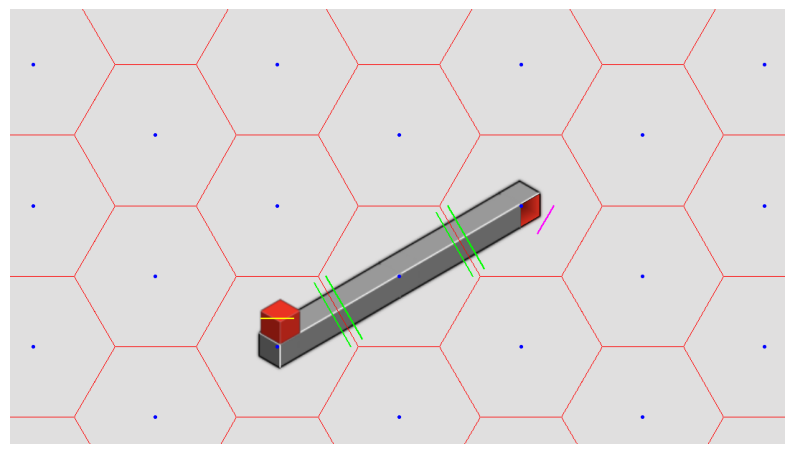


  Goal Dimension: 4
  Box Dimension: 0
  
3-2 (3, 0)
GOAL ON STRAIGHT LINE 2-4
3-2 [(3, 0)]
--------------------------------------------------
NO PATH FOUND


In [27]:
from mobileControls import take_screenshot, swipe
from time import sleep

count = 0
testing = False

while count < 1:
  image = take_screenshot() if not testing else getTestImage(7)
  grid = processImage(image, verbose=False, evaluate=True, showRefImage=False)
  maze = getMazeFromGrid(grid)

  maze.buildConnections()
  print("-"*50)
  swipes = maze.getSwipePath()
  count += 1

  if testing:
    continue
  
  for dim, w in swipes:
    swipe(dim)
    sleep(w * 1.25)
  sleep(7.5)